Resolving data files: 100%|██████████| 312/312 [00:00<00:00, 753815.00it/s]


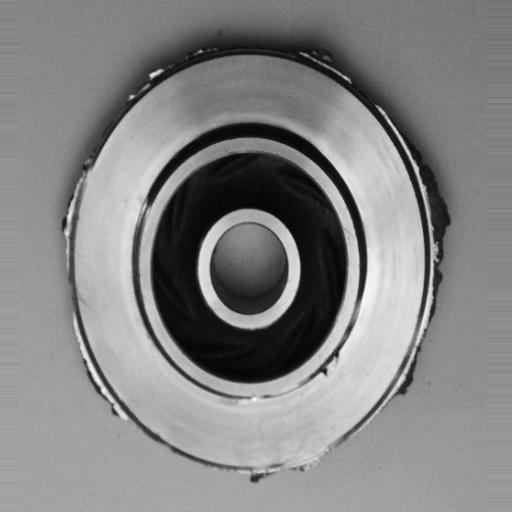

In [19]:
from datasets import load_dataset

dataset = load_dataset("dataset")
dataset["train"][0]["image"]

In [20]:
from transformers import ViTImageProcessor

model_name = "google/vit-base-patch16-224"
processor = ViTImageProcessor.from_pretrained(model_name)
# processor(dataset["train"][-1]["image"], return_tensors="pt")

In [21]:
def transform(batch):
    # Take a list of PIL images and turn them to pixel values
    inputs = processor([x for x in batch['image']], return_tensors='pt')

    # Don't forget to include the labels!
    inputs['label'] = batch['label']
    return inputs

prepared_ds = dataset.with_transform(transform)
# prepared_ds["train"][0]

In [22]:
import torch


def collate_fn(batch):
    return {
        "pixel_values": torch.stack([x["pixel_values"] for x in batch]),
        "labels": torch.tensor([x["label"] for x in batch]),
    }

In [23]:
import numpy as np
from datasets import load_metric

metric = load_metric("accuracy")
def compute_metrics(p):
    return metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)

In [24]:
from transformers import ViTForImageClassification

labels = dataset['train'].features['label'].names

model = ViTForImageClassification.from_pretrained(
    model_name,
    num_labels=len(labels),
    id2label={str(i): c for i, c in enumerate(labels)},
    label2id={c: str(i) for i, c in enumerate(labels)},
    ignore_mismatched_sizes=True
)


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [25]:
from transformers import TrainingArguments

training_args = TrainingArguments(
  output_dir="./vit-base-pcb",
  per_device_train_batch_size=16,
  evaluation_strategy="steps",
  num_train_epochs=4,
  # fp16=True,
  save_steps=100,
  eval_steps=100,
  logging_steps=10,
  learning_rate=2e-4,
  save_total_limit=2,
  remove_unused_columns=False,
  push_to_hub=False,
  report_to='tensorboard',
  load_best_model_at_end=True,
)

In [26]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=prepared_ds["train"],
    eval_dataset=prepared_ds["test"],
    tokenizer=processor,
)

In [28]:
train_results = trainer.train(resume_from_checkpoint=True)
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

 48%|████▊     | 109/228 [07:59<49:58, 25.19s/it]

KeyboardInterrupt: 

In [ ]:
metrics = trainer.evaluate(prepared_ds['test'])
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)